# Frequency correlation plots for natural populations with nested clades from a full tree

Example code for how to calculate frequency correlation plots from augur forecasting builds.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
min_clade_frequency = 0.15

In [7]:
precision = 4

In [8]:
data_root = "../results/builds/natural/natural_sample_0_with_90_vpm_sliding"

In [9]:
data_root_full_tree = "../results/builds/natural/natural_sample_0_with_90_vpm_sliding_full_tree"

In [10]:
first_validation_timepoint = "2005-10-01"

In [11]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [12]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [13]:
#tips = np.round(tips, precision)

In [14]:
np.round(tips.head(1), precision)

,strain,timepoint,frequency
3391,A/Aichi/113/2005,2005-10-01,0.0


In [15]:
(tips["frequency"] > 0).sum()

12139

In [16]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [17]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [18]:
tips_to_clades.head(20)

,strain,clade_membership,depth
0,A/HongKong/56/1994,b3aa7d8,0
1,A/HongKong/2/1994,19e1fb2,0
2,A/HongKong/2/1994,8e08f7f,2
3,A/HongKong/2/1994,b3aa7d8,3
4,A/Umea/1982/1992,bcf3094,0
5,A/Umea/1982/1992,19e1fb2,2
6,A/Umea/1982/1992,8e08f7f,3
7,A/Umea/1982/1992,b3aa7d8,4
8,A/Netherlands/165/1993,bcf3094,0
9,A/Netherlands/165/1993,19e1fb2,2


In [19]:
tips_to_clades.shape

(488505, 3)

In [20]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [21]:
#forecasts = np.round(forecasts, precision)

In [22]:
np.round(forecasts.head(1), 4)

,timepoint,strain,frequency,projected_frequency
0,1998-10-01,A/Christchurch/45/1998,0.0314,0.0016


In [23]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [24]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [25]:
#full_forecasts = np.round(full_forecasts, precision)

In [26]:
full_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
3391,2005-10-01,A/Aichi/113/2005,0.000032,6.269370,7.937148,0.762245,0.000010,5.606210,2006-10-01
3392,2005-10-01,A/Aichi/133/2005,0.000017,7.516969,9.232954,0.299436,0.000003,6.486119,2006-10-01
3393,2005-10-01,A/Aichi/145/2005,0.000138,7.253756,8.447406,0.543380,0.000034,6.597563,2006-10-01
3394,2005-10-01,A/Aichi/164/2005,0.000206,7.539313,9.279278,-1.979300,0.000004,6.488149,2006-10-01
3395,2005-10-01,A/Aichi/165/2005,0.001607,4.562649,4.605699,1.343866,0.000889,2.173264,2006-10-01


## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [27]:
tips.head()

,strain,timepoint,frequency
3391,A/Aichi/113/2005,2005-10-01,0.000032
3392,A/Aichi/133/2005,2005-10-01,0.000017
3393,A/Aichi/145/2005,2005-10-01,0.000138
3394,A/Aichi/164/2005,2005-10-01,0.000206
3395,A/Aichi/165/2005,2005-10-01,0.001607


In [28]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [29]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency
0,A/Illinois/9/2012,51b37c6,0,2012-10-01,0.003505
1,A/Illinois/9/2012,55aee48,3,2012-10-01,0.003505
2,A/Illinois/9/2012,763ba7c,5,2012-10-01,0.003505
3,A/Illinois/9/2012,7511705,6,2012-10-01,0.003505
4,A/Illinois/9/2012,02e323e,7,2012-10-01,0.003505


In [30]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [31]:
clade_tip_initial_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,future_timepoint
0,A/Illinois/9/2012,51b37c6,0,2012-10-01,0.003505,2013-10-01
1,A/Illinois/9/2012,55aee48,3,2012-10-01,0.003505,2013-10-01
2,A/Illinois/9/2012,763ba7c,5,2012-10-01,0.003505,2013-10-01
3,A/Illinois/9/2012,7511705,6,2012-10-01,0.003505,2013-10-01
4,A/Illinois/9/2012,02e323e,7,2012-10-01,0.003505,2013-10-01


In [32]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [33]:
initial_clade_frequencies.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2005-10-01,2006-10-01,02e323e,0.999976
1,2005-10-01,2006-10-01,048f8ca,0.999976
2,2005-10-01,2006-10-01,054ca27,0.021212
3,2005-10-01,2006-10-01,058a85c,0.004405
4,2005-10-01,2006-10-01,05a6dc1,0.021212


In [34]:
initial_clade_frequencies.query("clade_membership == '8517059'")

,timepoint,future_timepoint,clade_membership,frequency
72,2005-10-01,2006-10-01,8517059,0.016044
226,2006-04-01,2007-04-01,8517059,0.304336
369,2006-10-01,2007-10-01,8517059,0.266351
509,2007-04-01,2008-04-01,8517059,0.003662
658,2007-10-01,2008-10-01,8517059,0.000286


Merge clade frequencies between adjacent years.

In [35]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

In [36]:
initial_and_observed_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final
0,2005-10-01,02e323e,0.999976,1.000002
1,2005-10-01,048f8ca,0.999976,1.000002
2,2005-10-01,09e68a2,0.999976,1.000002
3,2005-10-01,1518fdb,0.000090,0.148332
4,2005-10-01,1d65d84,0.005592,0.000108


In [37]:
initial_and_observed_clade_frequencies.query("clade_membership == 'cb64469'")

,timepoint,clade_membership,frequency,frequency_final


Select clades with an initial frequency >15%.

In [38]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

In [39]:
large_clades.head()

,timepoint,clade_membership,frequency,frequency_final
0,2005-10-01,02e323e,0.999976,1.000002
1,2005-10-01,048f8ca,0.999976,1.000002
2,2005-10-01,09e68a2,0.999976,1.000002
5,2005-10-01,26f855a,0.572141,0.946808
6,2005-10-01,2806112,0.231124,0.001333


In [40]:
large_clades.tail()

,timepoint,clade_membership,frequency,frequency_final
1295,2014-10-01,e64cc68,0.999987,0.999997
1297,2014-10-01,ea08d9e,0.230692,0.885642
1298,2014-10-01,ecf49fd,0.999987,0.999997
1300,2014-10-01,f2ec31a,0.999987,0.999997
1301,2014-10-01,f3f16af,0.999987,0.999997


In [41]:
large_clades.shape

(784, 4)

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [42]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [43]:
clade_tip_estimated_frequencies.head()

,strain,clade_membership,depth,timepoint,frequency,projected_frequency
0,A/Kyongbuk/304/2002,5d540d1,0,2003-04-01,0.000553,0.000321
1,A/Kyongbuk/304/2002,02e323e,2,2003-04-01,0.000553,0.000321
2,A/Kyongbuk/304/2002,35491c6,10,2003-04-01,0.000553,0.000321
3,A/Kyongbuk/304/2002,b3aa7d8,12,2003-04-01,0.000553,0.000321
4,A/Chongqing/3/1999,ded8857,0,1999-04-01,0.008659,0.000294


In [44]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [45]:
estimated_clade_frequencies.head()

,timepoint,clade_membership,projected_frequency
0,1998-10-01,029a558,0.001095
1,1998-10-01,02cc04f,0.122495
2,1998-10-01,02e323e,1.000000
3,1998-10-01,048f8ca,0.001728
4,1998-10-01,09e68a2,0.993146


In [46]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [47]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [48]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [49]:
complete_clade_frequencies.shape

(161, 5)

In [50]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)

In [51]:
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

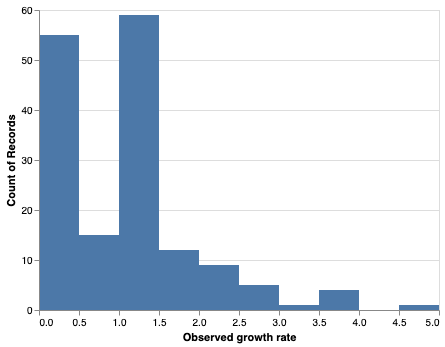

In [52]:
alt.Chart(complete_clade_frequencies).mark_rect().encode(
    x=alt.X("observed_growth_rate:Q", bin=True, title="Observed growth rate"),
    y="count()"
)

In [53]:
complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [54]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year
3,2005-10-01,26f855a,0.57,0.95,0.83,1.666667,1.456140,2005
4,2005-10-01,2806112,0.23,0.00,0.14,0.000000,0.608696,2005
6,2005-10-01,3a81d99,0.98,1.00,1.00,1.020408,1.020408,2005
7,2005-10-01,412c00a,0.98,1.00,1.00,1.020408,1.020408,2005
8,2005-10-01,44989e1,0.97,1.00,1.00,1.030928,1.030928,2005


In [55]:
complete_clade_frequencies.shape

(161, 8)

In [56]:
r, p = pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

In [57]:
r

0.4829668110930756

In [58]:
p

8.666529364153138e-11

In [59]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)

In [60]:
mcc

0.6242187651391702

In [61]:
confusion_matrix

{'tp': 84, 'tn': 47, 'fp': 23, 'fn': 7}

In [62]:
sum(confusion_matrix.values())

161

In [63]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.7850467289719626

In [64]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.8703703703703703

In [65]:
min_growth_rate = 0
max_growth_rate = complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [66]:
pseudofrequency = 0.001

In [67]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [68]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate
3,2005-10-01,26f855a,0.57,0.95,0.83,1.666667,1.456140,2005,0.221544,0.162965
4,2005-10-01,2806112,0.23,0.00,0.14,0.000000,0.608696,2005,-2.363612,-0.214393
6,2005-10-01,3a81d99,0.98,1.00,1.00,1.020408,1.020408,2005,0.008765,0.008765
7,2005-10-01,412c00a,0.98,1.00,1.00,1.020408,1.020408,2005,0.008765,0.008765
8,2005-10-01,44989e1,0.97,1.00,1.00,1.030928,1.030928,2005,0.013215,0.013215


In [69]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

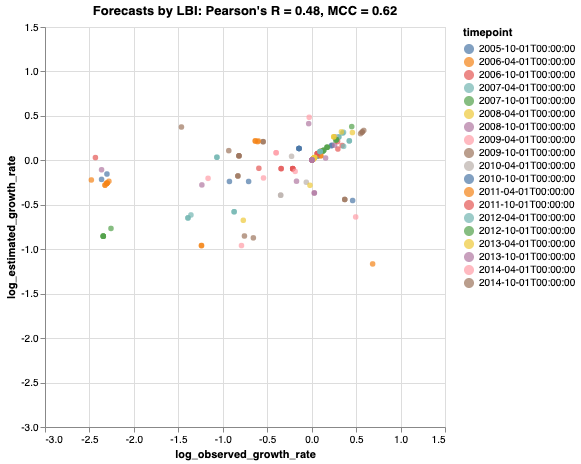

In [70]:
tooltip_attributes = ["observed_growth_rate:Q", "estimated_growth_rate:Q", "timepoint:N", "frequency:Q", "frequency_final:Q",
                      "projected_frequency:Q", "clade_membership:N"]

chart = alt.Chart(complete_clade_frequencies).mark_circle().encode(
    alt.X("log_observed_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Y("log_estimated_growth_rate:Q", scale=alt.Scale(domain=(log_lower_limit, log_upper_limit))),
    alt.Color("timepoint:N"),
    alt.Tooltip(tooltip_attributes)
).properties(
    width=400,
    height=400,
    title="Forecasts by LBI: Pearson's R = %.2f, MCC = %.2f" % (r, mcc)
).interactive()

#chart.save("forecast_log_growth_correlation_natural_lbi.svg")
chart

In [71]:
log_lower_limit

-2.5785664955938437

In [72]:
complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min()

-2.4785664955938436

In [73]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

In [74]:
r

0.5149472143002701

In [75]:
p

2.776139573022362e-12

In [76]:
pearsonr(
    complete_clade_frequencies["observed_growth_rate"],
    complete_clade_frequencies["estimated_growth_rate"]
)

(0.4829668110930756, 8.666529364153138e-11)

In [77]:
complete_clade_frequencies["observed_growth"] = (complete_clade_frequencies["observed_growth_rate"] > 1)

In [78]:
complete_clade_frequencies["estimated_growth"] = (complete_clade_frequencies["estimated_growth_rate"] > 1)

In [79]:
complete_clade_frequencies["accurate_growth"] = (
    (complete_clade_frequencies["observed_growth"]) == (complete_clade_frequencies["estimated_growth"])
)

In [80]:
confusion_matrix

{'tp': 84, 'tn': 47, 'fp': 23, 'fn': 7}

In [81]:
complete_clade_frequencies.head()

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
3,2005-10-01,26f855a,0.57,0.95,0.83,1.666667,1.456140,2005,0.221544,0.162965,True,True,True
4,2005-10-01,2806112,0.23,0.00,0.14,0.000000,0.608696,2005,-2.363612,-0.214393,False,False,True
6,2005-10-01,3a81d99,0.98,1.00,1.00,1.020408,1.020408,2005,0.008765,0.008765,True,True,True
7,2005-10-01,412c00a,0.98,1.00,1.00,1.020408,1.020408,2005,0.008765,0.008765,True,True,True
8,2005-10-01,44989e1,0.97,1.00,1.00,1.030928,1.030928,2005,0.013215,0.013215,True,True,True


In [82]:
(complete_clade_frequencies["estimated_growth_rate"] > 1).sum()

107

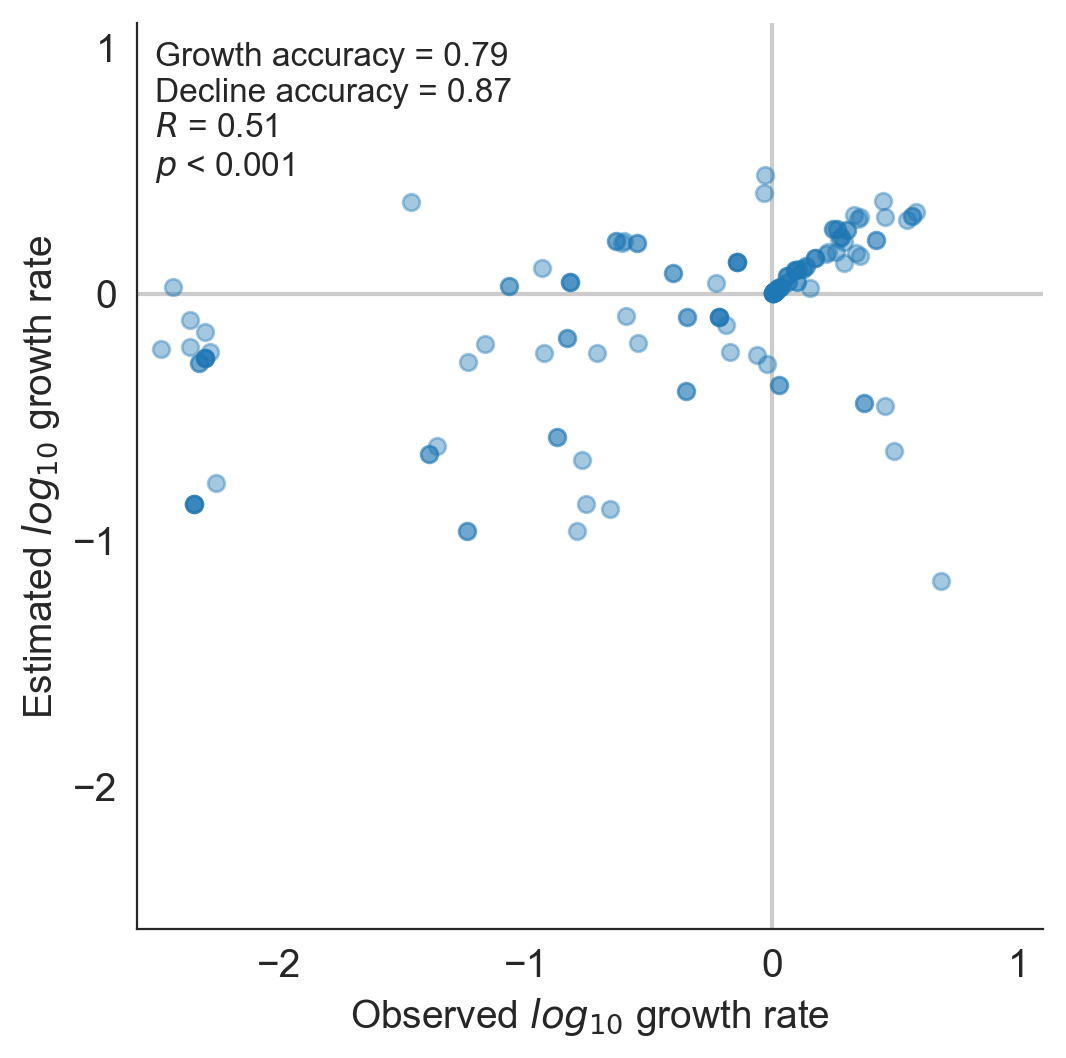

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

In [84]:
false_positives = (complete_clade_frequencies["log_observed_growth_rate"] < 0) & (complete_clade_frequencies["log_estimated_growth_rate"] > 0)

In [85]:
confusion_matrix

{'tp': 84, 'tn': 47, 'fp': 23, 'fn': 7}

In [86]:
complete_clade_frequencies[false_positives].sort_values("frequency")

,timepoint,clade_membership,frequency,frequency_final,projected_frequency,observed_growth_rate,estimated_growth_rate,year,log_observed_growth_rate,log_estimated_growth_rate,observed_growth,estimated_growth,accurate_growth
702,2014-04-01,80897ab,0.16,0.15,0.49,0.937500,3.062500,2014,-0.027849,0.484256,False,True,False
81,2006-10-01,8517059,0.27,0.00,0.29,0.000000,1.074074,2006,-2.432969,0.030924,False,True,False
329,2010-04-01,7fba9ff,0.27,0.16,0.30,0.592593,1.111111,2010,-0.226143,0.045597,False,True,False
628,2013-10-01,0165eeb,0.27,0.25,0.70,0.925926,2.592593,2013,-0.033296,0.412749,False,True,False
309,2009-10-01,e62a2e8,0.32,0.01,0.76,0.031250,2.375000,2009,-1.465112,0.374880,False,True,False
755,2014-10-01,80897ab,0.35,0.04,0.45,0.114286,1.285714,2014,-0.932523,0.108869,False,True,False
524,2012-04-01,c139e7c,0.36,0.03,0.39,0.083333,1.083333,2012,-1.066146,0.034670,False,True,False
514,2012-04-01,9449654,0.36,0.03,0.39,0.083333,1.083333,2012,-1.066146,0.034670,False,True,False
735,2014-10-01,1edac85,0.40,0.06,0.45,0.150000,1.125000,2014,-0.817815,0.051032,False,True,False
732,2014-10-01,07acbbd,0.40,0.06,0.45,0.150000,1.125000,2014,-0.817815,0.051032,False,True,False


## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [87]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [88]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [89]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [90]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2005-10-01,0.115217
1,2006-04-01,0.118863
2,2006-10-01,0.294737
3,2007-04-01,0.086605
4,2007-10-01,0.315565


Text(0,0.5,'Number of timepoints')

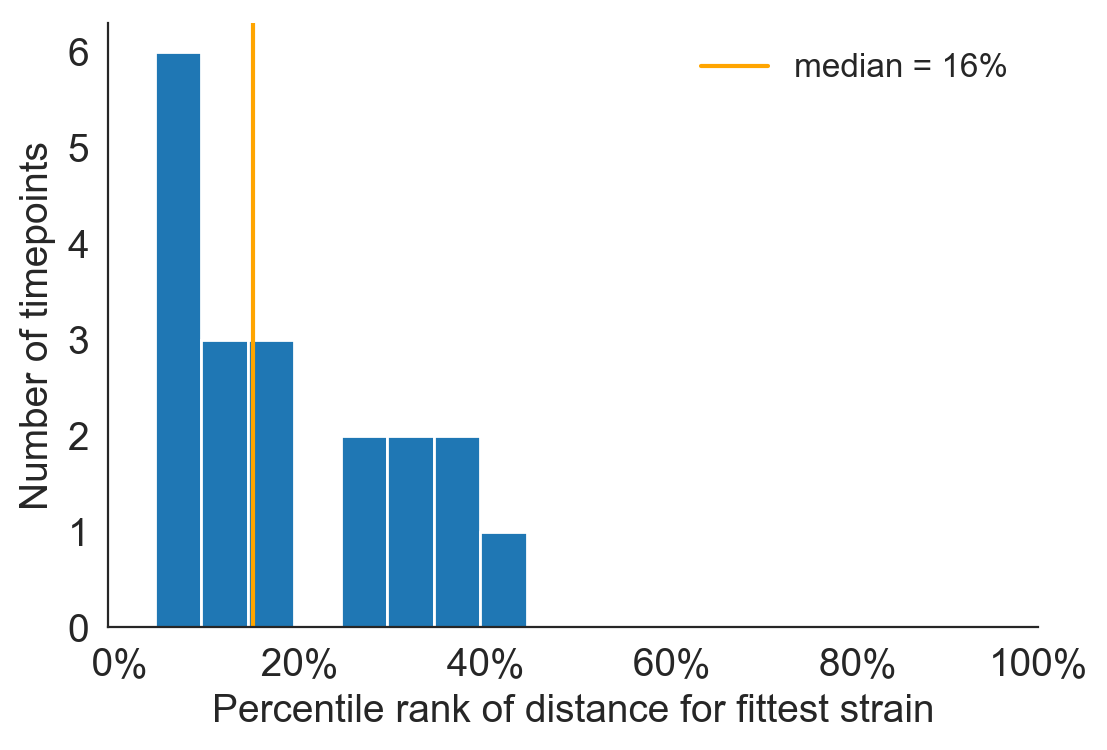

In [91]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

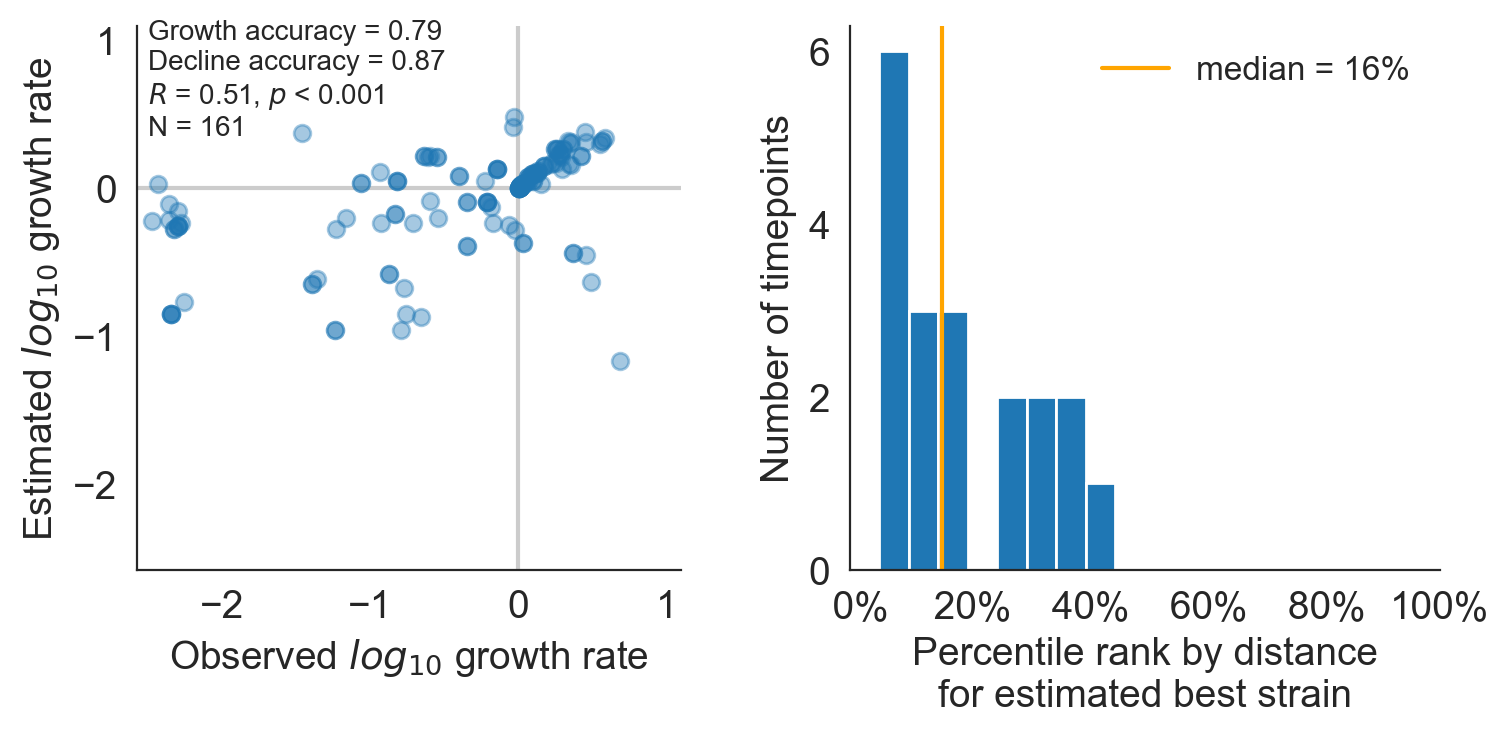

In [92]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f, %s\nN = %s" % (growth_accuracy, decline_accuracy, r, p_value, complete_clade_frequencies.shape[0]),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.png")

In [93]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] < 0.2).sum()

12

In [94]:
best_fitness_rank_by_timepoint_df.shape

(19, 2)

In [95]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.631578947368421